# Running `ws3` and `libcbm` as a two-stage sequential pipeline

We run `ws3` and `libcbm` in a two-stage sequential software pipeline. This is the _de facto_ standard way to run CBM models (i.e., run a forest estate model and CBM in a two-stage sequential pipeline, where the output from the first stage becomes the input for the second stage). The pipeline stages can be _hard linked_ (i.e., output from stage-1 model directly piped into stage-2 model at runtime, with no intermediate disk-based data drop), or _soft-linked_ (i.e., output from stage-1 model exported to disk in a specific format, then this same data is read and imported to stage-2 model). Either way, the result from running the pipeline should be the same. We demonstrate both approaches in this example.

Note that soft-linked version of this pipeline can be implemented using almost any combinination of forest estate model (e.g., ws3, Patchworks, Woodstock, FPS Atlas, Woodlot, etc.) and CBM (e.g., libcbm, CBM-CFS3, GCBM, spadesCBM, etc.), although an intermediary _data munging_ module might need to be included in the middle of the pipeline to link the two main stages if the forest estate model you are using does not include built-in soft-link data export functions that are compatible with the CBM implementation you are using. The data munging module could be a human manually reformatting raw stage-1 output data using a spreadsheet (simple, but yuck), a Jupyter or R markdown notebook that semi-automates (and documents) the data munging process, or a fully-automated software module.

`ws3` does not currently include built-in functions to export data for soft-link to CBM, so we implement some custom data munging code in this notebook (with examples of both soft- and hard-link approaches). One obvious advantage of selecting `ws3` and `libcbm` as the software modules for this two-stage pipeline is that they are both Python packages, which makes it easy to hard-link them with a bit of custom data munging Python code. 

Note that we plan to extend `ws3` at some point to include built-in `libcbm` soft-link and hard-link functions (similar to those implemented in this notebook). 

## Install `ws3` and `libcbm` packages

First, make sure we have the correct versions of `ws3` and `libcbm` installed. Both of these packages are relatively new and under active development, it is best we stick to known-working versions of each package from their respective GitHub repos. 


> We _strongly recommend_ that you run this notebook in venv-sandboxed Python kernel (see `venv_python_kernel_setup` notebook for an example of how to do this). This will ensure that you are working from a fresh Python package environment, and not wasting time debugging random interactions between this notebook and whatever mishmash of packages you have installed on your system in various parts of your Python path. You have been warned. 


Install `dev` branch of `ws3` package (from GitHub repo) into user space.

In [1]:
%pip install -U git+https://github.com/gparadis/ws3@dev

  Cloning https://github.com/gparadis/ws3 (to revision dev) to /media/data/tmp/pip-req-build-6xx9rln1
  Running command git clone --filter=blob:none --quiet https://github.com/gparadis/ws3 /media/data/tmp/pip-req-build-6xx9rln1
  Resolved https://github.com/gparadis/ws3 to commit c0d62626c67a954276783564367885e5cb9853da
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import ws3
ws3.__path__

['/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/ws3']

Install `main` branch of `libcbm_py` package (from GitHub repo) into user space.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main

  Cloning https://github.com/cat-cfs/libcbm_py.git (to revision main) to /media/data/tmp/pip-req-build-i4kfcryd
  Running command git clone --filter=blob:none --quiet https://github.com/cat-cfs/libcbm_py.git /media/data/tmp/pip-req-build-i4kfcryd
  Resolved https://github.com/cat-cfs/libcbm_py.git to commit 7f9b59ac22b2caba436653b518e1639a991bccb9
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [5]:
import libcbm
libcbm.__path__

['/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm']

Create a `ForestModel` instance by loading Woodstock-formatted input files.

In [6]:
import ws3.forest

In [7]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [8]:
fm = ws3.forest.ForestModel(model_name='tsa24_clipped',
                            model_path='data/woodstock_model_files',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

D

Schedule some harvesting using the self-parametrising priority queue heuristic defined in the local `util` module.

In [9]:
from util import schedule_harvest_areacontrol

In [10]:
sch = schedule_harvest_areacontrol(fm)

## Hard-link `ForestModel` to `libcbm`

Next, we compile some of the data from our `ForestModel` instance as `pandas.DataFrame` tables in the form expected by `libcbm.input.sit.sit_cbm_factory`. 

In [11]:
import pandas as pd

Show hints on expected data table formatting for the `sit_reader.parse` function.

### Compile yield data

In [12]:
species_classifier_colname = 'species'
leading_species_classifier_colname = 'leading_species'

In [13]:
nv = 100 # this MIGHT have to match the number of ages classes in sit_age_classes (not sure)

In [14]:
data = {'theme0':[], 'theme1':[], 'theme2':[], 'theme3':[], 'theme4':[], 
        species_classifier_colname:[], leading_species_classifier_colname:[], 
        **{'v%i' % i:[] for i in range(nv + 1)}}

In [15]:
#data = {'theme0':[], 'theme1':[], 'theme2':[], 'theme3':[], 'theme4':[], 'foo':[], 'bar':[], 
#        **{'v%i' % i:[] for i in range(nv + 1)}}

Load CANFI species data table.

In [16]:
canfi_species = pd.read_csv('data/canfi_species.csv')
canfi_species.set_index('canfi_species', inplace=True)

In [17]:
leading_species_from_dtype_key = {} # we will need this later (as leading_species needs to be a "classifier" in libcbm
for dtype_key, ytype, curves in fm.yields[:-1]:
    if ytype != 'a': continue
    for yname, curve in curves:
        for i in range(5): data['theme%i' % i].append(dtype_key[i])
        species = 'softwood' if int(yname[-4:]) < 1200 else 'hardwood' # CANFI species codes happen to be sorted by softwood/hardwood 
        leading_species_from_dtype_key[dtype_key] = species
        data[species_classifier_colname].append(species)
        data[leading_species_classifier_colname].append(species) # just a weird libcbm data model thing...
        #data['foo'].append(species)
        #data['bar'].append(species) # just a weird libcbm data model thing...
        for i in range(nv + 1): data['v%i' % i].append(curve[i * fm.period_length])

In [18]:
sit_yield = pd.DataFrame(data)

In [19]:
sit_yield

,theme0,theme1,theme2,theme3,theme4,species,leading_species,v0,v1,v2,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100
0,?,?,2401000,?,2401000,softwood,softwood,0.0,0.0,1.0,...,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0
1,?,?,2401000,?,2401000,softwood,softwood,0.0,0.0,1.0,...,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0
2,?,?,2402000,?,2402000,softwood,softwood,0.0,0.0,13.0,...,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0
3,?,?,2402000,?,2422000,softwood,softwood,0.0,0.0,0.0,...,336.0,336.0,336.0,336.0,336.0,336.0,336.0,336.0,336.0,336.0
4,?,?,2403000,?,2403000,softwood,softwood,0.0,0.0,14.0,...,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0
5,?,?,2403000,?,2423000,softwood,softwood,0.0,0.0,0.0,...,433.0,433.0,433.0,433.0,433.0,433.0,433.0,433.0,433.0,433.0
6,?,?,2401001,?,2401001,softwood,softwood,0.0,0.0,0.0,...,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0
7,?,?,2401001,?,2401001,softwood,softwood,0.0,0.0,0.0,...,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0
8,?,?,2402001,?,2402001,softwood,softwood,0.0,0.0,0.0,...,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0
9,?,?,2402001,?,2402001,softwood,softwood,0.0,0.0,0.0,...,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0


### Compile inventory. 

`ws3` "themes" map 1:1 to `libcbm` "classifiers".

Start by loading the Woodstock-formatted initial inventory input file.

In [20]:
names = ['_', 'theme0', 'theme1', 'theme2', 'theme3', 'theme4', 'age', 'area']
sit_inventory = pd.read_csv('data/woodstock_model_files/tsa24_clipped.are', 
                            delimiter=' ', header=None, names=names)

In [21]:
sit_inventory.head()

,_,theme0,theme1,theme2,theme3,theme4,age,area
0,*A,tsa24_clipped,0,2401000,100,2401000,85,15.182275
1,*A,tsa24_clipped,0,2401000,100,2401000,95,20.653789
2,*A,tsa24_clipped,0,2401000,100,2401000,105,1.109374
3,*A,tsa24_clipped,0,2401000,100,2401000,125,25.731748
4,*A,tsa24_clipped,0,2401000,100,2401000,135,62.023828


Drop useless column.

In [22]:
sit_inventory.drop('_', axis=1, inplace=True)

Add missing columns. First, we define a helper function that we cna use here (and later) to deduce the correct `leading_species` value (i.e., the sixth classifier) from a `pandas.Series` that includes the 5 themes in our `ws3` model.

In [23]:
def _leading_species(dtype_key):
    for mask, leading_species in leading_species_from_dtype_key.items():
        if fm.match_mask(mask, dtype_key):
            return leading_species
        
def __leading_species(r):
    dtype_key = tuple(str(r['theme%i' % i]) for i in range(5))
    return _leading_species(dtype_key)

In [24]:
sit_inventory[species_classifier_colname] = sit_inventory.apply(__leading_species, axis=1)
sit_inventory['using_age_class'] = 'FALSE'
sit_inventory['delay'] = 0
sit_inventory['landclass'] = 0
sit_inventory['historic_disturbance'] = 'fire'
sit_inventory['last_pass_disturbance'] = sit_inventory.apply(lambda r: 'fire' if r['theme2'] == r['theme4'] else 'harvest', axis=1)

The `landclass` column values should contain an integer in the range $[0, 22], which CBM maps to one of 23 UNFCCC land classes (see Table 3-1 in the the CBM-CFS3 user guide, shown below for convenience). We just use a value of 0 for all inventory records (i.e., "Forest land remaining forest land").

The `dist1` and `dist2` values in the `last_pass_disturbance` column correspond to fire and harvesting (and match the values used in the `disturbance_types` table defined a few cells down).

![UNFCCC land class values](images/cbmcfs3_ug_table3-1.png)

Shuffle columns to match order expected by `libcbm`.

In [25]:
names = ['theme0', 'theme1', 'theme2', 'theme3', 'theme4', species_classifier_colname,
         'using_age_class', 'age', 'area', 'delay', 'landclass', 
         'historic_disturbance', 'last_pass_disturbance']
sit_inventory = sit_inventory[names]

In [26]:
sit_inventory

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24_clipped,0,2401000,100,2401000,softwood,FALSE,85,15.182275,0,0,fire,fire
1,tsa24_clipped,0,2401000,100,2401000,softwood,FALSE,95,20.653789,0,0,fire,fire
2,tsa24_clipped,0,2401000,100,2401000,softwood,FALSE,105,1.109374,0,0,fire,fire
3,tsa24_clipped,0,2401000,100,2401000,softwood,FALSE,125,25.731748,0,0,fire,fire
4,tsa24_clipped,0,2401000,100,2401000,softwood,FALSE,135,62.023828,0,0,fire,fire
5,tsa24_clipped,0,2401000,100,2401000,softwood,FALSE,145,45.322290,0,0,fire,fire
6,tsa24_clipped,0,2401000,100,2401000,softwood,FALSE,155,3.052804,0,0,fire,fire
7,tsa24_clipped,0,2402005,1201,2402005,hardwood,FALSE,85,1.812979,0,0,fire,fire
8,tsa24_clipped,1,2401002,204,2401002,softwood,FALSE,78,103.767403,0,0,fire,fire
9,tsa24_clipped,1,2401002,204,2401002,softwood,FALSE,80,4.173147,0,0,fire,fire


### Compile classifiers

In [27]:
data = {'classifier_id':[], 'name':[], 'description':[]}
for i in range(5):
    data['classifier_id'].append(i+1)
    data['name'].append('_CLASSIFIER')
    data['description'].append('theme%i' % i)
    for v in fm.theme_basecodes(i):
        data['classifier_id'].append(i+1)
        data['name'].append(v)
        data['description'].append(v) # these are not very good descriptions, but will not affect CBM model output

data['classifier_id'].append(6)
data['name'].append('_CLASSIFIER')
data['description'].append(species_classifier_colname) 

data['classifier_id'].append(6)
data['name'].append('softwood')
data['description'].append('softwood') 

data['classifier_id'].append(6)
data['name'].append('hardwood')
data['description'].append('hardwood') 

sit_classifiers = pd.DataFrame(data)

In [28]:
sit_classifiers

,classifier_id,name,description
0,1,_CLASSIFIER,theme0
1,1,tsa24_clipped,tsa24_clipped
2,2,_CLASSIFIER,theme1
3,2,0,0
4,2,1,1
...,...,...,...
72,5,2423000,2423000
73,5,2403001,2403001
74,6,_CLASSIFIER,species
75,6,softwood,softwood


### Compile disturbance types

In [29]:
data = {'id':['harvest', 'fire'], 
        'name':['harvest', 'fire']}
sit_disturbance_types = pd.DataFrame(data)

### Compile age classes

In [30]:
data = {'name':['age_0'],
        'class_size':[0],
        'start_year':[0],
        'end_year':[0]}
for i, ac in enumerate(range(period_length, max_age+period_length, period_length)):
    data['name'].append('age_%i' % (i+1))
    data['class_size'].append(period_length)
    data['start_year'].append(ac - period_length + 1)
    data['end_year'].append(ac)
sit_age_classes = pd.DataFrame(data)

In [31]:
sit_age_classes

,name,class_size,start_year,end_year
0,age_0,0,0,0
1,age_1,10,1,10
2,age_2,10,11,20
3,age_3,10,21,30
4,age_4,10,31,40
...,...,...,...,...
96,age_96,10,951,960
97,age_97,10,961,970
98,age_98,10,971,980
99,age_99,10,981,990


### Compile events

In [32]:
columns = ['theme0',
           'theme1',
           'theme2',
           'theme3',
           'theme4',
           species_classifier_colname,
           'using_age_class',
           'min_softwood_age',
           'max_softwood_age',
           'min_hardwood_age',
           'max_hardwood_age',
           'MinYearsSinceDist',
           'MaxYearsSinceDist',
           'LastDistTypeID',
           'MinTotBiomassC',
           'MaxTotBiomassC',
           'MinSWMerchBiomassC',
           'MaxSWMerchBiomassC',
           'MinHWMerchBiomassC',
           'MaxHWMerchBiomassC',
           'MinTotalStemSnagC',
           'MaxTotalStemSnagC',	
           'MinSWStemSnagC',
           'MaxSWStemSnagC',
           'MinHWStemSnagC',
           'MaxHWStemSnagC',
           'MinTotalStemSnagMerchC',
           'MaxTotalStemSnagMerchC',
           'MinSWMerchStemSnagC',
           'MaxSWMerchStemSnagC',
           'MinHWMerchStemSnagC',
           'MaxHWMerchStemSnagC',
           'efficiency',
           'sort_type',
           'target_type',
           'target',
           'disturbance_type',
           'disturbance_year']

In [33]:
data = {c:[] for c in columns}

In [34]:
for dtype_key, age, area, acode, period, _ in sch:
    for i in range(5): data['theme%i' % i].append(dtype_key[i])
    data[species_classifier_colname].append(_leading_species(dtype_key))
    data['using_age_class'].append('FALSE')
    data['min_softwood_age'].append(1)
    data['max_softwood_age'].append(999)
    data['min_hardwood_age'].append(1)
    data['max_hardwood_age'].append(999)
    for c in columns[11:-6]: data[c].append(-1)
    data['efficiency'].append(1)
    data['sort_type'].append(3) # oldest first (see Table 3-3 in the CBM-CFS3 user guide)
    data['target_type'].append('A') # area target
    data['target'].append(area)
    data['disturbance_type'].append(acode)
    data['disturbance_year'].append(period*fm.period_length)
sit_events = pd.DataFrame(data)

In [35]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa24_clipped,1,2402002,204,2402002,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,3.195379,harvest,10
1,tsa24_clipped,1,2402002,204,2402002,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,3.971358,harvest,10
2,tsa24_clipped,1,2402002,204,2422002,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,6.390758,harvest,10
3,tsa24_clipped,1,2402000,100,2402000,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,0.056965,harvest,10
4,tsa24_clipped,1,2401002,204,2401002,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,34.326292,harvest,10
5,tsa24_clipped,1,2401002,204,2421002,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,60.171699,harvest,10
6,tsa24_clipped,1,2403002,204,2403002,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,2.243991,harvest,10
7,tsa24_clipped,1,2403002,204,2423002,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,8.244849,harvest,10
8,tsa24_clipped,1,2403000,100,2403000,softwood,FALSE,1,999,1,...,-1,-1,-1,-1,1,3,A,1.481164,harvest,10


To do: figure out what Woodstock export does to make sure that exported schedules map harvesting events to the correct age class (not just oldest first, which is stupid and inaccurate).

### Compile transitions

In [36]:
au_table = pd.read_csv('data/au_table.csv')
au_table1 = au_table.set_index('au_id')
au_table2 = au_table.set_index('managed_curve_id')

In [37]:
columns = ['theme0',
           'theme1',
           'theme2',
           'theme3',
           'theme4',
           species_classifier_colname,
           'using_age_class',
           'min_softwood_age',
           'max_softwood_age',
           'min_hardwood_age',
           'max_hardwood_age',
           'disturbance_type',
           'to_theme0',
           'to_theme1',
           'to_theme2',
           'to_theme3',
           'to_theme4',
           'to_%s' % species_classifier_colname,
           'regen_delay',
           'reset_age',
           'percent']
data = {c:[] for c in columns}
for acode in fm.transitions:
    if acode != 'harvest': continue
    for smask in fm.transitions[acode]:
        tmask, tprop, _, _, _, _, _ = fm.transitions[acode][smask][''][0]
        for i in range(5): data['theme%i' % i].append(smask[i])
        data[species_classifier_colname].append('softwood' if au_table1.loc[int(smask[2])].canfi_species < 1200 else 'hardwood')
        data['using_age_class'].append('FALSE')
        data['min_softwood_age'].append(1)
        data['max_softwood_age'].append(999)
        data['min_hardwood_age'].append(1)
        data['max_hardwood_age'].append(999)
        data['disturbance_type'].append('harvest')
        for i in range(5): data['to_theme%i' % i].append(tmask[i])
        data['to_%s' % species_classifier_colname].append('softwood' if au_table2.loc[int(tmask[4])].canfi_species < 1200 else 'hardwood')
        data['regen_delay'].append(0)
        data['reset_age'].append(0)
        data['percent'].append(100)
sit_transitions = pd.DataFrame(data)

In [38]:
sit_transitions

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,disturbance_type,to_theme0,to_theme1,to_theme2,to_theme3,to_theme4,to_species,regen_delay,reset_age,percent
0,?,?,2402000,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,2422000,softwood,0,0,100
1,?,?,2403000,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,2423000,softwood,0,0,100
2,?,?,2403001,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,2423001,softwood,0,0,100
3,?,?,2401002,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,2421002,softwood,0,0,100
4,?,?,2402002,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,2422002,softwood,0,0,100
5,?,?,2403002,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,2423002,softwood,0,0,100
6,?,?,2402003,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,2422003,softwood,0,0,100
7,?,?,2403003,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,2423003,softwood,0,0,100
8,?,?,2402004,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,2422004,softwood,0,0,100
9,?,?,2403004,?,?,softwood,FALSE,1,999,1,...,harvest,?,?,?,?,2423004,softwood,0,0,100


### Import data into and run `libcbm`

In [39]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 

Compile the data tables we created into a `sit_data` object.

In [40]:
sit_data = None
sit_yield.columns

Index(['theme0', 'theme1', 'theme2', 'theme3', 'theme4', 'species',
       'leading_species', 'v0', 'v1', 'v2',
       ...
       'v91', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99', 'v100'],
      dtype='object', length=108)

In [41]:
sit_data = sit_reader.parse(sit_classifiers=sit_classifiers,
                            sit_disturbance_types=sit_disturbance_types,
                            sit_age_classes=sit_age_classes,
                            sit_inventory=sit_inventory,
                            sit_yield=sit_yield,
                            sit_events=sit_events,
                            sit_transitions=sit_transitions,
                            sit_eligibilities=None)

Create a `config` namespace object that has the same structure we would have if we loaded  a `sit_config.json` JSON file into memory using the `json` module.

In [42]:
sit_config = {
    'mapping_config': {
        'nonforest': None,
        'species': {
            'species_classifier': species_classifier_colname,
            'species_mapping': [
                {'user_species': 'softwood', 'default_species': 'Softwood forest type'},
                {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}
            ]
        },
        'spatial_units': {
            'mapping_mode': 'SingleDefaultSpatialUnit',
            'admin_boundary': 'British Columbia',
            'eco_boundary': 'Montane Cordillera'},
        'disturbance_types': {
            'disturbance_type_mapping': [
                {'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}
            ]
        }
    }
}

In [43]:
sit = sit_cbm_factory.initialize_sit(sit_data=sit_data, config=sit_config)

In [44]:
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)

In [45]:
classifiers.to_pandas()

,theme0,theme1,theme2,theme3,theme4,species
0,1,2,19,29,58,70
1,1,2,19,29,58,70
2,1,2,19,29,58,70
3,1,2,19,29,58,70
4,1,2,19,29,58,70
5,1,2,19,29,58,70
6,1,2,19,29,58,70
7,1,2,20,30,59,71
8,1,3,16,31,54,70
9,1,3,16,31,54,70


In [46]:
inventory.to_pandas()

,age,spatial_unit,afforestation_pre_type_id,area,delay,land_class,historical_disturbance_type,last_pass_disturbance_type
0,85,42,-1.0,15.182275,0,0,2,2
1,95,42,-1.0,20.653789,0,0,2,2
2,105,42,-1.0,1.109374,0,0,2,2
3,125,42,-1.0,25.731748,0,0,2,2
4,135,42,-1.0,62.023828,0,0,2,2
5,145,42,-1.0,45.322290,0,0,2,2
6,155,42,-1.0,3.052804,0,0,2,2
7,85,42,-1.0,1.812979,0,0,2,2
8,78,42,-1.0,103.767403,0,0,2,2
9,80,42,-1.0,4.173147,0,0,2,2


In [47]:
from libcbm.model.cbm.cbm_output import CBMOutput

cbm_output = CBMOutput(
    classifier_map=sit.classifier_value_names,
    disturbance_type_map=sit.disturbance_name_map)

In [48]:
sit.disturbance_name_map

{0: '', 1: 'harvest', 2: 'fire'}

In [49]:
from libcbm.storage.backends import BackendType
from libcbm.model.cbm import cbm_simulator

In [50]:
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(
        cbm,
        n_steps              = 200,
        classifiers          = classifiers,
        inventory            = inventory,
        pre_dynamics_func    = rule_based_processor.pre_dynamics_func,
        reporting_func       = cbm_output.append_simulation_result,
        backend_type = BackendType.numpy
    )

/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm/resources/__init__.py:113: RuntimeWarning: unsupported linux distribution: Linux-5.15.0-46-generic-x86_64-with-glibc2.35
  warnings.warn(message, RuntimeWarning)


In [51]:
cbm_output.classifiers.to_pandas()

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species
0,1,0,tsa24_clipped,0,2401000,100,2401000,softwood
1,2,0,tsa24_clipped,0,2401000,100,2401000,softwood
2,3,0,tsa24_clipped,0,2401000,100,2401000,softwood
3,4,0,tsa24_clipped,0,2401000,100,2401000,softwood
4,5,0,tsa24_clipped,0,2401000,100,2401000,softwood
...,...,...,...,...,...,...,...,...
7191,32,200,tsa24_clipped,1,2403002,204,2423002,softwood
7192,33,200,tsa24_clipped,1,2402002,204,2402002,softwood
7193,34,200,tsa24_clipped,1,2402000,100,2402000,softwood
7194,35,200,tsa24_clipped,1,2403002,204,2423002,softwood


#### Pool Results

In [52]:
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), left_on=["identifier", "timestep"], right_on=["identifier", "timestep"])

In [53]:
pi.head()

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,Input,SoftwoodMerch,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,tsa24_clipped,0,2401000,100,2401000,softwood,15.182275,373.069726,...,1065.383223,44.664652,21.805691,0.0,0.0,91657.150249,91.647046,824.798708,0.0,0.0
1,2,0,tsa24_clipped,0,2401000,100,2401000,softwood,20.653789,604.793715,...,1454.061073,60.222298,30.899322,0.0,0.0,125273.907594,124.675567,1122.046497,0.0,0.0
2,3,0,tsa24_clipped,0,2401000,100,2401000,softwood,1.109374,37.600351,...,78.465996,3.402234,1.722309,0.0,0.0,6761.100385,6.696684,60.268349,0.0,0.0
3,4,0,tsa24_clipped,0,2401000,100,2401000,softwood,25.731748,1098.080842,...,1843.781536,94.529783,42.749353,0.0,0.0,158382.608301,155.328417,1397.913879,0.0,0.0
4,5,0,tsa24_clipped,0,2401000,100,2401000,softwood,62.023828,2894.224484,...,4480.400346,250.937444,106.132134,0.0,0.0,383721.376936,374.403745,3369.532778,0.0,0.0


<Axes: xlabel='Year'>

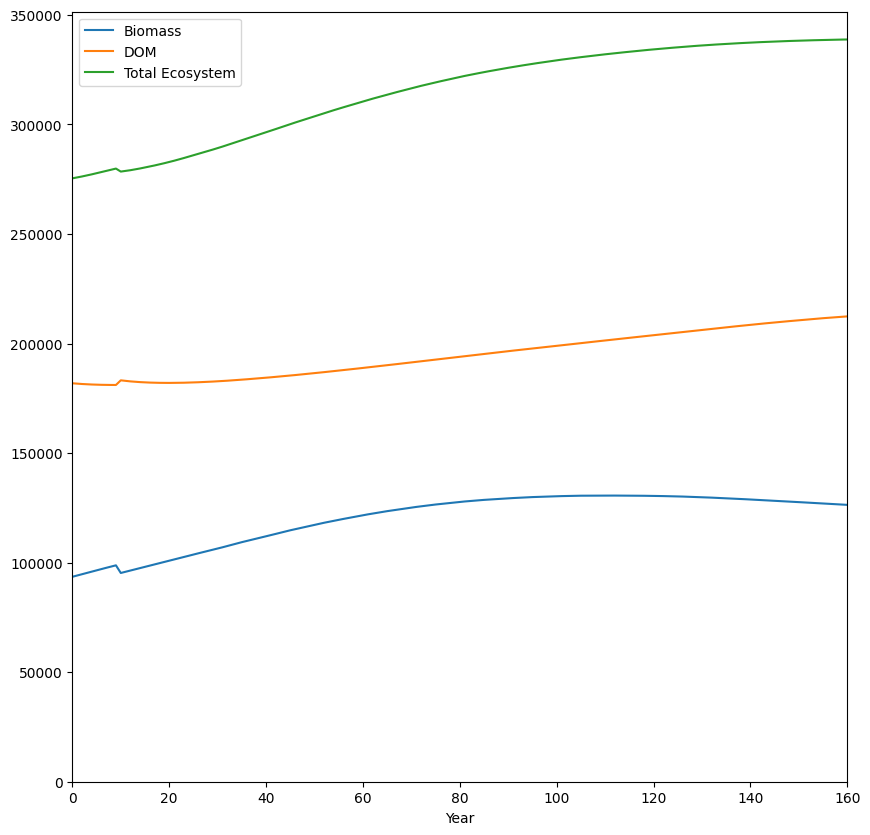

In [54]:
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']

dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

biomass_result = pi[['timestep']+biomass_pools]
dom_result = pi[['timestep']+dom_pools]
total_eco_result = pi[['timestep']+biomass_pools+dom_pools]

annual_carbon_stocks = pd.DataFrame(
    {
        "Year": pi["timestep"],
        "Biomass": pi[biomass_pools].sum(axis=1),
        "DOM": pi[dom_pools].sum(axis=1),
        "Total Ecosystem": pi[biomass_pools+dom_pools].sum(axis=1)})

annual_carbon_stocks.groupby("Year").sum().plot(figsize=(10,10),xlim=(0,160),ylim=(0,None))

#### State Variable Results

In [55]:
si = cbm_output.state.to_pandas()

In [56]:
si.head()

,identifier,timestep,last_disturbance_type,time_since_last_disturbance,time_since_land_class_change,growth_enabled,enabled,land_class,age,growth_multiplier,regeneration_delay
0,1,0,fire,85,-1,1,1,0,85,1.0,0
1,2,0,fire,95,-1,1,1,0,95,1.0,0
2,3,0,fire,105,-1,1,1,0,105,1.0,0
3,4,0,fire,125,-1,1,1,0,125,1.0,0
4,5,0,fire,135,-1,1,1,0,135,1.0,0


<Axes: xlabel='timestep'>

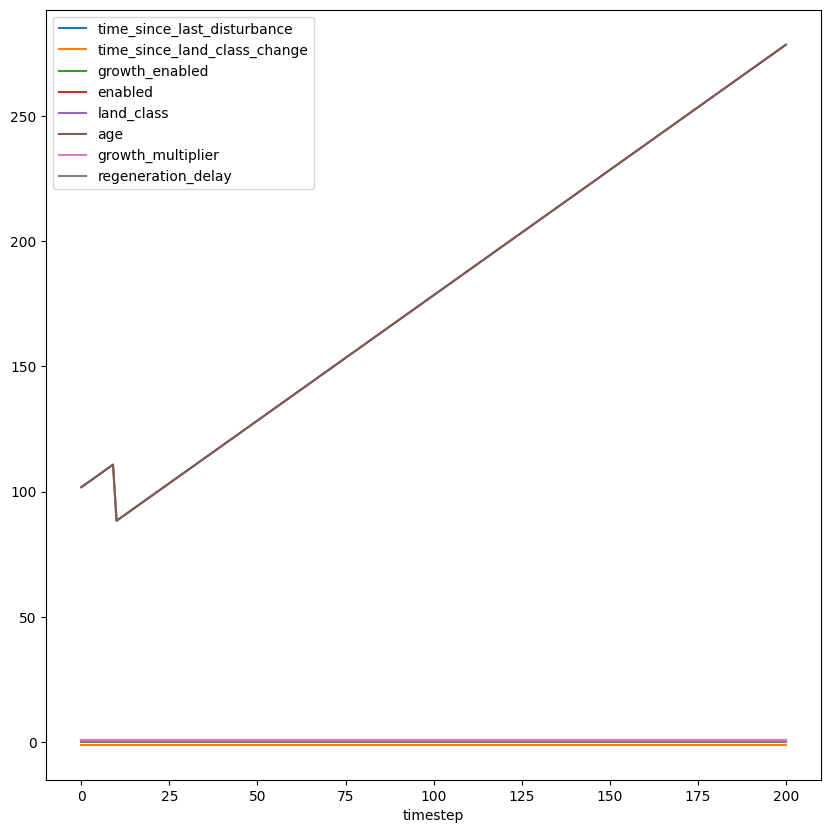

In [57]:
state_variables = ['timestep', 'time_since_last_disturbance', 'time_since_land_class_change',
 'growth_enabled', 'enabled', 'land_class', 'age', 'growth_multiplier', 'regeneration_delay']
si[state_variables].groupby('timestep').mean().plot(figsize=(10,10))

#### Flux Indicators

In [58]:
fi = cbm_output.flux.to_pandas()

In [59]:
fi.head()

,identifier,timestep,DisturbanceCO2Production,DisturbanceCH4Production,DisturbanceCOProduction,DisturbanceBioCO2Emission,DisturbanceBioCH4Emission,DisturbanceBioCOEmission,DecayDOMCO2Emission,DisturbanceSoftProduction,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']

<Axes: xlabel='timestep'>

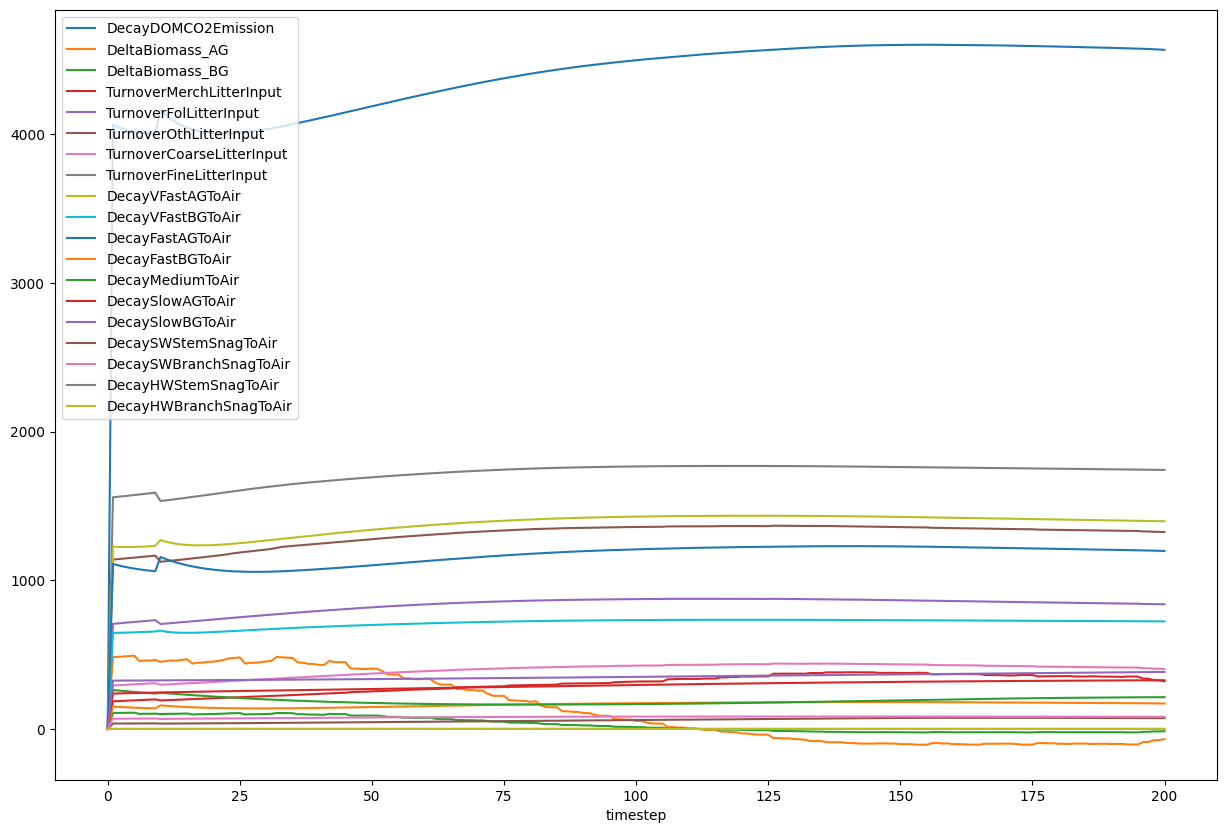

In [61]:
fi[["timestep"]+annual_process_fluxes].groupby("timestep").sum().plot(figsize=(15,10))

#### Disturbance Statistics

In [62]:
rule_based_processor.sit_event_stats_by_timestep[1]

In [63]:
rule_based_processor.sit_events

,theme0,theme1,theme2,theme3,theme4,species,min_age,max_age,MinYearsSinceDist,MaxYearsSinceDist,...,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,time_step,disturbance_type_id,sort_field
0,tsa24_clipped,1,2402002,204,2402002,softwood,1,999,-1,-1,...,-1,-1,1,SORT_BY_SW_AGE,Area,3.195379,harvest,10,1,1
1,tsa24_clipped,1,2402002,204,2402002,softwood,1,999,-1,-1,...,-1,-1,1,SORT_BY_SW_AGE,Area,3.971358,harvest,10,1,1
2,tsa24_clipped,1,2402002,204,2422002,softwood,1,999,-1,-1,...,-1,-1,1,SORT_BY_SW_AGE,Area,6.390758,harvest,10,1,1
3,tsa24_clipped,1,2402000,100,2402000,softwood,1,999,-1,-1,...,-1,-1,1,SORT_BY_SW_AGE,Area,0.056965,harvest,10,1,1
4,tsa24_clipped,1,2401002,204,2401002,softwood,1,999,-1,-1,...,-1,-1,1,SORT_BY_SW_AGE,Area,34.326292,harvest,10,1,1
5,tsa24_clipped,1,2401002,204,2421002,softwood,1,999,-1,-1,...,-1,-1,1,SORT_BY_SW_AGE,Area,60.171699,harvest,10,1,1
6,tsa24_clipped,1,2403002,204,2403002,softwood,1,999,-1,-1,...,-1,-1,1,SORT_BY_SW_AGE,Area,2.243991,harvest,10,1,1
7,tsa24_clipped,1,2403002,204,2423002,softwood,1,999,-1,-1,...,-1,-1,1,SORT_BY_SW_AGE,Area,8.244849,harvest,10,1,1
8,tsa24_clipped,1,2403000,100,2403000,softwood,1,999,-1,-1,...,-1,-1,1,SORT_BY_SW_AGE,Area,1.481164,harvest,10,1,1


#### Appendix

#### SIT source data

In [64]:
sit.sit_data.age_classes

,name,class_size,start_year,end_year
0,age_0,0,0,0
1,age_1,10,1,10
2,age_2,10,11,20
3,age_3,10,21,30
4,age_4,10,31,40
...,...,...,...,...
96,age_96,10,951,960
97,age_97,10,961,970
98,age_98,10,971,980
99,age_99,10,981,990


In [65]:
sit.sit_data.inventory

,theme0,theme1,theme2,theme3,theme4,species,age,area,delay,land_class,historical_disturbance_type,last_pass_disturbance_type
0,tsa24_clipped,0,2401000,100,2401000,softwood,85,15.182275,0,0,fire,fire
1,tsa24_clipped,0,2401000,100,2401000,softwood,95,20.653789,0,0,fire,fire
2,tsa24_clipped,0,2401000,100,2401000,softwood,105,1.109374,0,0,fire,fire
3,tsa24_clipped,0,2401000,100,2401000,softwood,125,25.731748,0,0,fire,fire
4,tsa24_clipped,0,2401000,100,2401000,softwood,135,62.023828,0,0,fire,fire
5,tsa24_clipped,0,2401000,100,2401000,softwood,145,45.322290,0,0,fire,fire
6,tsa24_clipped,0,2401000,100,2401000,softwood,155,3.052804,0,0,fire,fire
7,tsa24_clipped,0,2402005,1201,2402005,hardwood,85,1.812979,0,0,fire,fire
8,tsa24_clipped,1,2401002,204,2401002,softwood,78,103.767403,0,0,fire,fire
9,tsa24_clipped,1,2401002,204,2401002,softwood,80,4.173147,0,0,fire,fire


In [66]:
sit.sit_data.classifiers

,id,name
0,1,theme0
1,2,theme1
2,3,theme2
3,4,theme3
4,5,theme4
5,6,species


In [67]:
sit.sit_data.classifier_values

,classifier_id,name,description
1,1,tsa24_clipped,tsa24_clipped
3,2,0,0
4,2,1,1
6,3,2402002,2402002
7,3,2401007,2401007
...,...,...,...
71,5,2401001,2401001
72,5,2423000,2423000
73,5,2403001,2403001
75,6,softwood,softwood


In [68]:
sit.sit_data.disturbance_types

,sit_disturbance_type_id,id,name
0,1,harvest,harvest
1,2,fire,fire


In [69]:
sit.sit_data.disturbance_events

,theme0,theme1,theme2,theme3,theme4,species,min_age,max_age,MinYearsSinceDist,MaxYearsSinceDist,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,time_step
0,tsa24_clipped,1,2402002,204,2402002,softwood,1,999,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,3.195379,harvest,10
1,tsa24_clipped,1,2402002,204,2402002,softwood,1,999,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,3.971358,harvest,10
2,tsa24_clipped,1,2402002,204,2422002,softwood,1,999,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,6.390758,harvest,10
3,tsa24_clipped,1,2402000,100,2402000,softwood,1,999,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,0.056965,harvest,10
4,tsa24_clipped,1,2401002,204,2401002,softwood,1,999,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,34.326292,harvest,10
5,tsa24_clipped,1,2401002,204,2421002,softwood,1,999,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,60.171699,harvest,10
6,tsa24_clipped,1,2403002,204,2403002,softwood,1,999,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,2.243991,harvest,10
7,tsa24_clipped,1,2403002,204,2423002,softwood,1,999,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,8.244849,harvest,10
8,tsa24_clipped,1,2403000,100,2403000,softwood,1,999,-1,-1,...,-1,-1,-1,-1,1,SORT_BY_SW_AGE,Area,1.481164,harvest,10


In [70]:
sit.sit_data.transition_rules

,theme0,theme1,theme2,theme3,theme4,species,min_age,max_age,disturbance_type,theme0_tr,theme1_tr,theme2_tr,theme3_tr,theme4_tr,species_tr,regeneration_delay,reset_age,percent
0,?,?,2402000,?,?,softwood,1,999,harvest,?,?,?,?,2422000,softwood,0,0,100
1,?,?,2403000,?,?,softwood,1,999,harvest,?,?,?,?,2423000,softwood,0,0,100
2,?,?,2403001,?,?,softwood,1,999,harvest,?,?,?,?,2423001,softwood,0,0,100
3,?,?,2401002,?,?,softwood,1,999,harvest,?,?,?,?,2421002,softwood,0,0,100
4,?,?,2402002,?,?,softwood,1,999,harvest,?,?,?,?,2422002,softwood,0,0,100
5,?,?,2403002,?,?,softwood,1,999,harvest,?,?,?,?,2423002,softwood,0,0,100
6,?,?,2402003,?,?,softwood,1,999,harvest,?,?,?,?,2422003,softwood,0,0,100
7,?,?,2403003,?,?,softwood,1,999,harvest,?,?,?,?,2423003,softwood,0,0,100
8,?,?,2402004,?,?,softwood,1,999,harvest,?,?,?,?,2422004,softwood,0,0,100
9,?,?,2403004,?,?,softwood,1,999,harvest,?,?,?,?,2423004,softwood,0,0,100


In [71]:
sit.sit_data.yield_table

,theme0,theme1,theme2,theme3,theme4,species,leading_species,v0,v1,v2,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100
0,?,?,2401000,?,2401000,softwood,194,0.0,0.0,1.0,...,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0
1,?,?,2401000,?,2401000,softwood,194,0.0,0.0,1.0,...,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0
2,?,?,2402000,?,2402000,softwood,194,0.0,0.0,13.0,...,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0
3,?,?,2402000,?,2422000,softwood,194,0.0,0.0,0.0,...,336.0,336.0,336.0,336.0,336.0,336.0,336.0,336.0,336.0,336.0
4,?,?,2403000,?,2403000,softwood,194,0.0,0.0,14.0,...,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0
5,?,?,2403000,?,2423000,softwood,194,0.0,0.0,0.0,...,433.0,433.0,433.0,433.0,433.0,433.0,433.0,433.0,433.0,433.0
6,?,?,2401001,?,2401001,softwood,194,0.0,0.0,0.0,...,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0
7,?,?,2401001,?,2401001,softwood,194,0.0,0.0,0.0,...,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0
8,?,?,2402001,?,2402001,softwood,194,0.0,0.0,0.0,...,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0
9,?,?,2402001,?,2402001,softwood,194,0.0,0.0,0.0,...,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0


In [72]:
import json

In [73]:
print(json.dumps(sit.config, indent=4, sort_keys=True))

{
    "mapping_config": {
        "disturbance_types": {
            "disturbance_type_mapping": [
                {
                    "default_dist_type": "Clearcut harvesting without salvage",
                    "user_dist_type": "harvest"
                },
                {
                    "default_dist_type": "Wildfire",
                    "user_dist_type": "fire"
                }
            ]
        },
        "nonforest": null,
        "spatial_units": {
            "admin_boundary": "British Columbia",
            "eco_boundary": "Montane Cordillera",
            "mapping_mode": "SingleDefaultSpatialUnit"
        },
        "species": {
            "species_classifier": "species",
            "species_mapping": [
                {
                    "default_species": "Softwood forest type",
                    "user_species": "softwood"
                },
                {
                    "default_species": "Hardwood forest type",
                    "user_spec

## Soft-link `ws3` and `libcbm`

In this section, we will dump the `libcbm` input data we created in above to appropriately named and formatted data files on disk, and load them into `libcbm` using the built-in SIT import functions.

Extend the `sit_config` namespace object to include missing filename information under the `import_config` key.

In [74]:
sit_config.update({'import_config':{
                       'classifiers':       {'type':'csv', 'params':{'path':'sit_classifiers.csv'}},
                       'disturbance_types': {'type':'csv', 'params':{'path':'sit_disturbance_types.csv'}},
                       'age_classes':       {'type': 'csv', 'params': {'path': 'sit_age_classes.csv'}},
                       'inventory':         {'type': 'csv', 'params': {'path': 'sit_inventory.csv'}},
                       'yield':             {'type': 'csv', 'params': {'path': 'sit_yield.csv'}},
                       'events':            {'type': 'csv', 'params': {'path': 'sit_events.csv'}},
                       'transitions': 	    {'type': 'csv', 'params': {'path': 'sit_transitions.csv'}}}})

In [75]:
json.dump(sit_config, open('data/libcbm_model_files/sit_config.json', 'w'), indent=4, sort_keys=True)

In [76]:
json.load(open('data/sit_config.json'))

{'import_config': {'classifiers': {'type': 'csv',
   'params': {'path': 'sit_classifiers.csv'}},
  'disturbance_types': {'type': 'csv',
   'params': {'path': 'sit_disturbance_tyeps.csv'}},
  'age_classes': {'type': 'csv', 'params': {'path': 'sit_age_classes.csv'}},
  'inventory': {'type': 'csv', 'params': {'path': 'sit_inventory.csv'}},
  'yield': {'type': 'csv', 'params': {'path': 'sit_yield.csv'}},
  'events': {'type': 'csv', 'params': {'path': 'sit_events.csv'}},
  'transitions': {'type': 'csv', 'params': {'path': 'sit_ransitions.csv'}}},
 'mapping_config': {'nonforest': None,
  'species': {'species_classifier': 'species',
   'species_mapping': [{'user_species': 'softwood',
     'default_species': 'Softwood forest type'},
    {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}]},
  'spatial_units': {'mapping_mode': 'SingleDefaultSpatialUnit',
   'admin_boundary': 'British Columbia',
   'eco_boundary': 'Montane Cordillera'},
  'disturbance_types': {'disturbance_ty

Now dump the data tables to CSV files.

In [77]:
sit_classifiers.to_csv('data/libcbm_model_files/sit_classifiers.csv', index=False)

In [78]:
pd.read_csv('data/libcbm_model_files/sit_classifiers.csv')

,classifier_id,name,description
0,1,_CLASSIFIER,theme0
1,1,tsa24_clipped,tsa24_clipped
2,2,_CLASSIFIER,theme1
3,2,0,0
4,2,1,1
...,...,...,...
72,5,2423000,2423000
73,5,2403001,2403001
74,6,_CLASSIFIER,species
75,6,softwood,softwood


In [79]:
sit_disturbance_types.to_csv('data/libcbm_model_files/sit_disturbance_types.csv', index=False)

In [80]:
pd.read_csv('data/libcbm_model_files/sit_disturbance_types.csv')

,id,name
0,harvest,harvest
1,fire,fire


In [81]:
sit_age_classes.to_csv('data/libcbm_model_files/sit_age_classes.csv', index=False)

In [82]:
pd.read_csv('data/libcbm_model_files/sit_age_classes.csv')

,name,class_size,start_year,end_year
0,age_0,0,0,0
1,age_1,10,1,10
2,age_2,10,11,20
3,age_3,10,21,30
4,age_4,10,31,40
...,...,...,...,...
96,age_96,10,951,960
97,age_97,10,961,970
98,age_98,10,971,980
99,age_99,10,981,990


In [83]:
sit_inventory.to_csv('data/libcbm_model_files/sit_inventory.csv', index=False)

In [84]:
pd.read_csv('data/libcbm_model_files/sit_inventory.csv')

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24_clipped,0,2401000,100,2401000,softwood,False,85,15.182275,0,0,fire,fire
1,tsa24_clipped,0,2401000,100,2401000,softwood,False,95,20.653789,0,0,fire,fire
2,tsa24_clipped,0,2401000,100,2401000,softwood,False,105,1.109374,0,0,fire,fire
3,tsa24_clipped,0,2401000,100,2401000,softwood,False,125,25.731748,0,0,fire,fire
4,tsa24_clipped,0,2401000,100,2401000,softwood,False,135,62.023828,0,0,fire,fire
5,tsa24_clipped,0,2401000,100,2401000,softwood,False,145,45.322290,0,0,fire,fire
6,tsa24_clipped,0,2401000,100,2401000,softwood,False,155,3.052804,0,0,fire,fire
7,tsa24_clipped,0,2402005,1201,2402005,hardwood,False,85,1.812979,0,0,fire,fire
8,tsa24_clipped,1,2401002,204,2401002,softwood,False,78,103.767403,0,0,fire,fire
9,tsa24_clipped,1,2401002,204,2401002,softwood,False,80,4.173147,0,0,fire,fire


In [85]:
sit_yield.to_csv('data/libcbm_model_files/sit_yield.csv', index=False)

In [86]:
pd.read_csv('data/libcbm_model_files/sit_yield.csv')

,theme0,theme1,theme2,theme3,theme4,species,leading_species,v0,v1,v2,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100
0,?,?,2401000,?,2401000,softwood,softwood,0.0,0.0,1.0,...,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0
1,?,?,2401000,?,2401000,softwood,softwood,0.0,0.0,1.0,...,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0,145.0
2,?,?,2402000,?,2402000,softwood,softwood,0.0,0.0,13.0,...,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0,235.0
3,?,?,2402000,?,2422000,softwood,softwood,0.0,0.0,0.0,...,336.0,336.0,336.0,336.0,336.0,336.0,336.0,336.0,336.0,336.0
4,?,?,2403000,?,2403000,softwood,softwood,0.0,0.0,14.0,...,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0
5,?,?,2403000,?,2423000,softwood,softwood,0.0,0.0,0.0,...,433.0,433.0,433.0,433.0,433.0,433.0,433.0,433.0,433.0,433.0
6,?,?,2401001,?,2401001,softwood,softwood,0.0,0.0,0.0,...,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0
7,?,?,2401001,?,2401001,softwood,softwood,0.0,0.0,0.0,...,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0
8,?,?,2402001,?,2402001,softwood,softwood,0.0,0.0,0.0,...,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0
9,?,?,2402001,?,2402001,softwood,softwood,0.0,0.0,0.0,...,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0,144.0


In [87]:
sit_events.to_csv('data/libcbm_model_files/sit_events.csv', index=False)

In [88]:
pd.read_csv('data/libcbm_model_files/sit_events.csv')

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa24_clipped,1,2402002,204,2402002,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,3.195379,harvest,10
1,tsa24_clipped,1,2402002,204,2402002,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,3.971358,harvest,10
2,tsa24_clipped,1,2402002,204,2422002,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,6.390758,harvest,10
3,tsa24_clipped,1,2402000,100,2402000,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,0.056965,harvest,10
4,tsa24_clipped,1,2401002,204,2401002,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,34.326292,harvest,10
5,tsa24_clipped,1,2401002,204,2421002,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,60.171699,harvest,10
6,tsa24_clipped,1,2403002,204,2403002,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,2.243991,harvest,10
7,tsa24_clipped,1,2403002,204,2423002,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,8.244849,harvest,10
8,tsa24_clipped,1,2403000,100,2403000,softwood,False,1,999,1,...,-1,-1,-1,-1,1,3,A,1.481164,harvest,10


In [89]:
sit_transitions.to_csv('data/libcbm_model_files/sit_transitions.csv', index=False)

In [90]:
pd.read_csv('data/libcbm_model_files/sit_transitions.csv')

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,disturbance_type,to_theme0,to_theme1,to_theme2,to_theme3,to_theme4,to_species,regen_delay,reset_age,percent
0,?,?,2402000,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,2422000,softwood,0,0,100
1,?,?,2403000,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,2423000,softwood,0,0,100
2,?,?,2403001,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,2423001,softwood,0,0,100
3,?,?,2401002,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,2421002,softwood,0,0,100
4,?,?,2402002,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,2422002,softwood,0,0,100
5,?,?,2403002,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,2423002,softwood,0,0,100
6,?,?,2402003,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,2422003,softwood,0,0,100
7,?,?,2403003,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,2423003,softwood,0,0,100
8,?,?,2402004,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,2422004,softwood,0,0,100
9,?,?,2403004,?,?,softwood,False,1,999,1,...,harvest,?,?,?,?,2423004,softwood,0,0,100


Now we can soft-link to `libcbm` using the built-in data file import functions. 

In [91]:
sit = sit_cbm_factory.load_sit('data/libcbm_model_files/sit_config.json')

In [92]:
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)

In [93]:
cbm_output = CBMOutput(
    classifier_map=sit.classifier_value_names,
    disturbance_type_map=sit.disturbance_name_map)

In [94]:
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(
        cbm,
        n_steps              = 200,
        classifiers          = classifiers,
        inventory            = inventory,
        pre_dynamics_func    = rule_based_processor.pre_dynamics_func,
        reporting_func       = cbm_output.append_simulation_result,
        backend_type = BackendType.numpy
    )

/media/data/home/gparadis/.virtualenvs/foo/lib/python3.10/site-packages/libcbm/resources/__init__.py:113: RuntimeWarning: unsupported linux distribution: Linux-5.15.0-46-generic-x86_64-with-glibc2.35
  warnings.warn(message, RuntimeWarning)


In [95]:
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), left_on=["identifier", "timestep"], right_on=["identifier", "timestep"])

In [96]:
pi.head()

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,Input,SoftwoodMerch,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,tsa24_clipped,0,2401000,100,2401000,softwood,15.182275,373.069726,...,1065.383223,44.664652,21.805691,0.0,0.0,91657.150249,91.647046,824.798708,0.0,0.0
1,2,0,tsa24_clipped,0,2401000,100,2401000,softwood,20.653789,604.793715,...,1454.061073,60.222298,30.899322,0.0,0.0,125273.907594,124.675567,1122.046497,0.0,0.0
2,3,0,tsa24_clipped,0,2401000,100,2401000,softwood,1.109374,37.600351,...,78.465996,3.402234,1.722309,0.0,0.0,6761.100385,6.696684,60.268349,0.0,0.0
3,4,0,tsa24_clipped,0,2401000,100,2401000,softwood,25.731748,1098.080842,...,1843.781536,94.529783,42.749353,0.0,0.0,158382.608301,155.328417,1397.913879,0.0,0.0
4,5,0,tsa24_clipped,0,2401000,100,2401000,softwood,62.023828,2894.224484,...,4480.400346,250.937444,106.132134,0.0,0.0,383721.376936,374.403745,3369.532778,0.0,0.0


<Axes: xlabel='Year'>

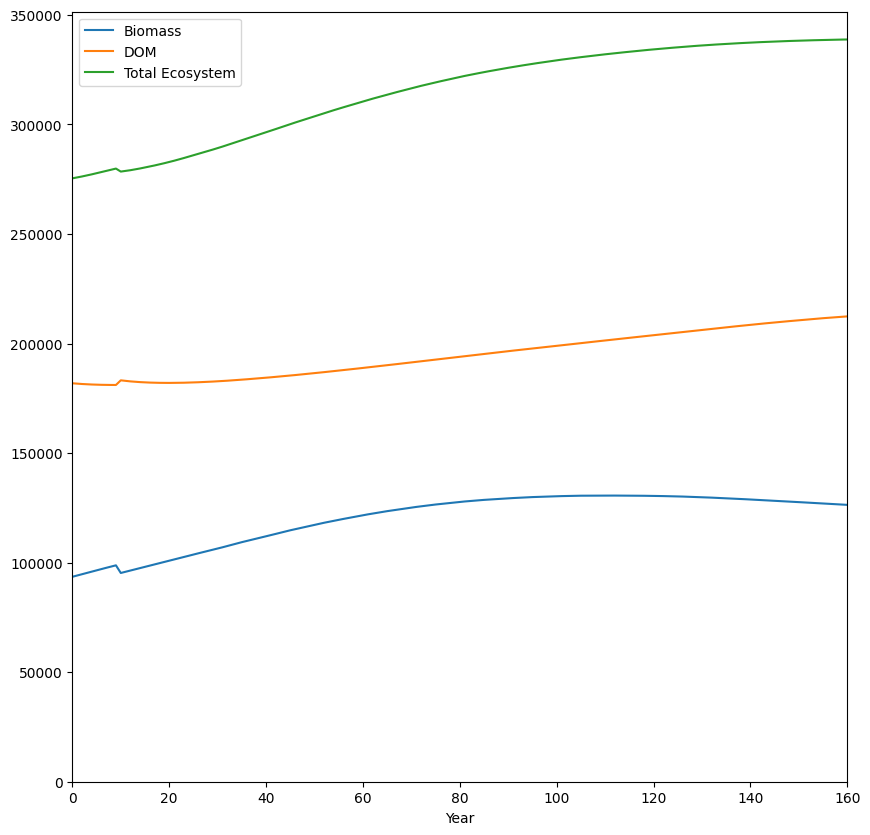

In [97]:
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']

dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

biomass_result = pi[['timestep']+biomass_pools]
dom_result = pi[['timestep']+dom_pools]
total_eco_result = pi[['timestep']+biomass_pools+dom_pools]

annual_carbon_stocks = pd.DataFrame(
    {
        "Year": pi["timestep"],
        "Biomass": pi[biomass_pools].sum(axis=1),
        "DOM": pi[dom_pools].sum(axis=1),
        "Total Ecosystem": pi[biomass_pools+dom_pools].sum(axis=1)})

annual_carbon_stocks.groupby("Year").sum().plot(figsize=(10,10),xlim=(0,160),ylim=(0,None))

Ta da! Too easy!